# TOV Star Cowling Approximation Test (Engrenage)

This notebook implements the ELH paper "Isolated star in the Cowling approximation" test 
for the Engrenage 1D spherical numerical relativity code.

We implement:
- ELH paper parameters (Γ=2, K=100, ρ_c=1.28e-3, r_max=16, Δr=0.2)  
- TOV initial data with proper static metric
- Cowling approximation evolution (fixed spacetime, evolving matter)
- Baryon mass conservation monitoring
- ELH Figures 11 & 12 reproduction

The Cowling approximation freezes the spacetime metric at the TOV solution while evolving only 
the hydrodynamics, allowing for clean tests of matter conservation properties.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, sys, time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d

from scipy.integrate import trapezoid
# Robustly locate the Engrenage repo root so we can import `source.*` modules
def locate_repo_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / 'source').is_dir() and (candidate / 'examples').is_dir():
            return candidate
    raise RuntimeError('Could not find repo root containing `source/` directory')

NOTEBOOK_DIR = Path.cwd()
repo_root = locate_repo_root(NOTEBOOK_DIR)
source_path = repo_root / 'source'
for path in (repo_root, source_path):
    path_str = str(path)
    if path_str not in sys.path:
        sys.path.append(path_str)

# Engrenage imports - following BHEvolution.ipynb structure
from core.spacing import LinearSpacing, SpacingExtent, NUM_GHOSTS
from core.grid import Grid
from core.statevector import StateVector
from backgrounds.sphericalbackground import FlatSphericalBackground, i_r, i_t, i_p
from matter.hydro.perfect_fluid import PerfectFluid
from matter.hydro.eos import PolytropicEOS
from matter.hydro.reconstruction import create_reconstruction
from matter.hydro.riemann import HLLERiemannSolver
from matter.hydro.cons2prim import cons_to_prim
from bssn.bssnstatevariables import *
from bssn.constraintsdiagnostic import *
from core.rhsevolution import *
from core.display import *

print('Environment ready. Repo root =', repo_root)

Environment ready. Repo root = /home/yo/repositories/engrenage


/home/yo/repositories/engrenage/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parameters

In [2]:
# Paper-like TOV parameters (ELH 4.2.1)
gamma = 2.0                # Γ para evolución ideal-fluid
K = 100.0                  # K (en unidades geométricas de ELH)
rho_central = 1.28e-3      # densidad central del test ELH

# Malla de prueba tipo ELH (1D esférico)
r_max = 16.0               # frontera externa ~16 M_sun
dr = 0.01                   # Δr ~ 0.2 M_sun
N = int(r_max / dr)        # número de celdas (luego se añaden ghosts internamente)

print(f'ELH params: Γ={gamma}, K={K}, ρ_c={rho_central}, r_max={r_max}, N={N}, dr={dr}')

ELH params: Γ=2.0, K=100.0, ρ_c=0.00128, r_max=16.0, N=1600, dr=0.01


## TOV ODE Solver (standalone)

In [3]:
def solve_tov_ode(r_max, rho_central, gamma, K=1.0, n_points=1000):
    """Solve TOV equations for a cold polytropic star.
    Returns dict with r, rho, pressure, mass, alpha, R_star, M_star.
    """
    # Central pressure from polytropic EOS: p = K rho^Γ
    p_central = K * rho_central**gamma

    def energy_density_from_pressure(P):
        if P <= 0:
            return 1e-15
        rho = (P / K)**(1.0/gamma)
        eps = P / ((gamma - 1.0) * rho)
        return rho * (1.0 + eps)

    def tov_rhs(y, r):
        m, p = y
        if r < 1e-12:
            return np.array([0.0, 0.0])
        e = energy_density_from_pressure(p)
        dmdr = 4.0 * np.pi * r**2 * e
        denom = r * (r - 2*m)
        dpdr = 0.0 if abs(denom) < 1e-15 else -(e + p) * (m + 4*np.pi * r**3 * p) / denom
        return np.array([dmdr, dpdr])

    r_start = 1e-6
    e_central = energy_density_from_pressure(p_central)
    m_start = (4.0 * np.pi / 3.0) * e_central * r_start**3
    p_start = p_central

    r_span = np.linspace(r_start, r_max, n_points)
    sol = odeint(tov_rhs, [m_start, p_start], r_span)
    mass_profile = sol[:, 0]
    pressure_profile = sol[:, 1]

    # Surface where p → 0
    surface_idx = np.where(pressure_profile <= 1e-15)[0]
    if len(surface_idx) > 0:
        R_star = r_span[surface_idx[0]]
        M_star = mass_profile[surface_idx[0]]
    else:
        R_star = r_max
        M_star = mass_profile[-1]

    # rho from p via EOS
    rho_profile = np.full_like(pressure_profile, 1e-15)
    mask = pressure_profile > 1e-15
    rho_profile[mask] = (pressure_profile[mask] / K)**(1.0/gamma)

    # Lapse alpha(r) via dPhi/dr and integration
    dPhi_dr = np.zeros_like(r_span)
    for i, ri in enumerate(r_span):
        if ri > 1e-12:
            mi = mass_profile[i]
            Pi = pressure_profile[i]
            denom = ri * (ri - 2*mi)
            if abs(denom) > 1e-14:
                dPhi_dr[i] = (mi + 4*np.pi * ri**3 * Pi) / denom
    Phi = np.zeros_like(r_span)
    for i in range(1, len(r_span)):
        dr = r_span[i] - r_span[i-1]
        Phi[i] = Phi[i-1] + 0.5 * (dPhi_dr[i] + dPhi_dr[i-1]) * dr
    alpha = np.exp(Phi)
    if alpha[-1] > 1e-12:
        alpha = alpha / alpha[-1]

    return {
        'r': r_span,
        'rho': rho_profile,
        'pressure': pressure_profile,
        'mass': mass_profile,
        'alpha': alpha,
        'R_star': R_star,
        'M_star': M_star,
        'K': K,
        'gamma': gamma
    }

print('TOV ODE solver defined.')

TOV ODE solver defined.


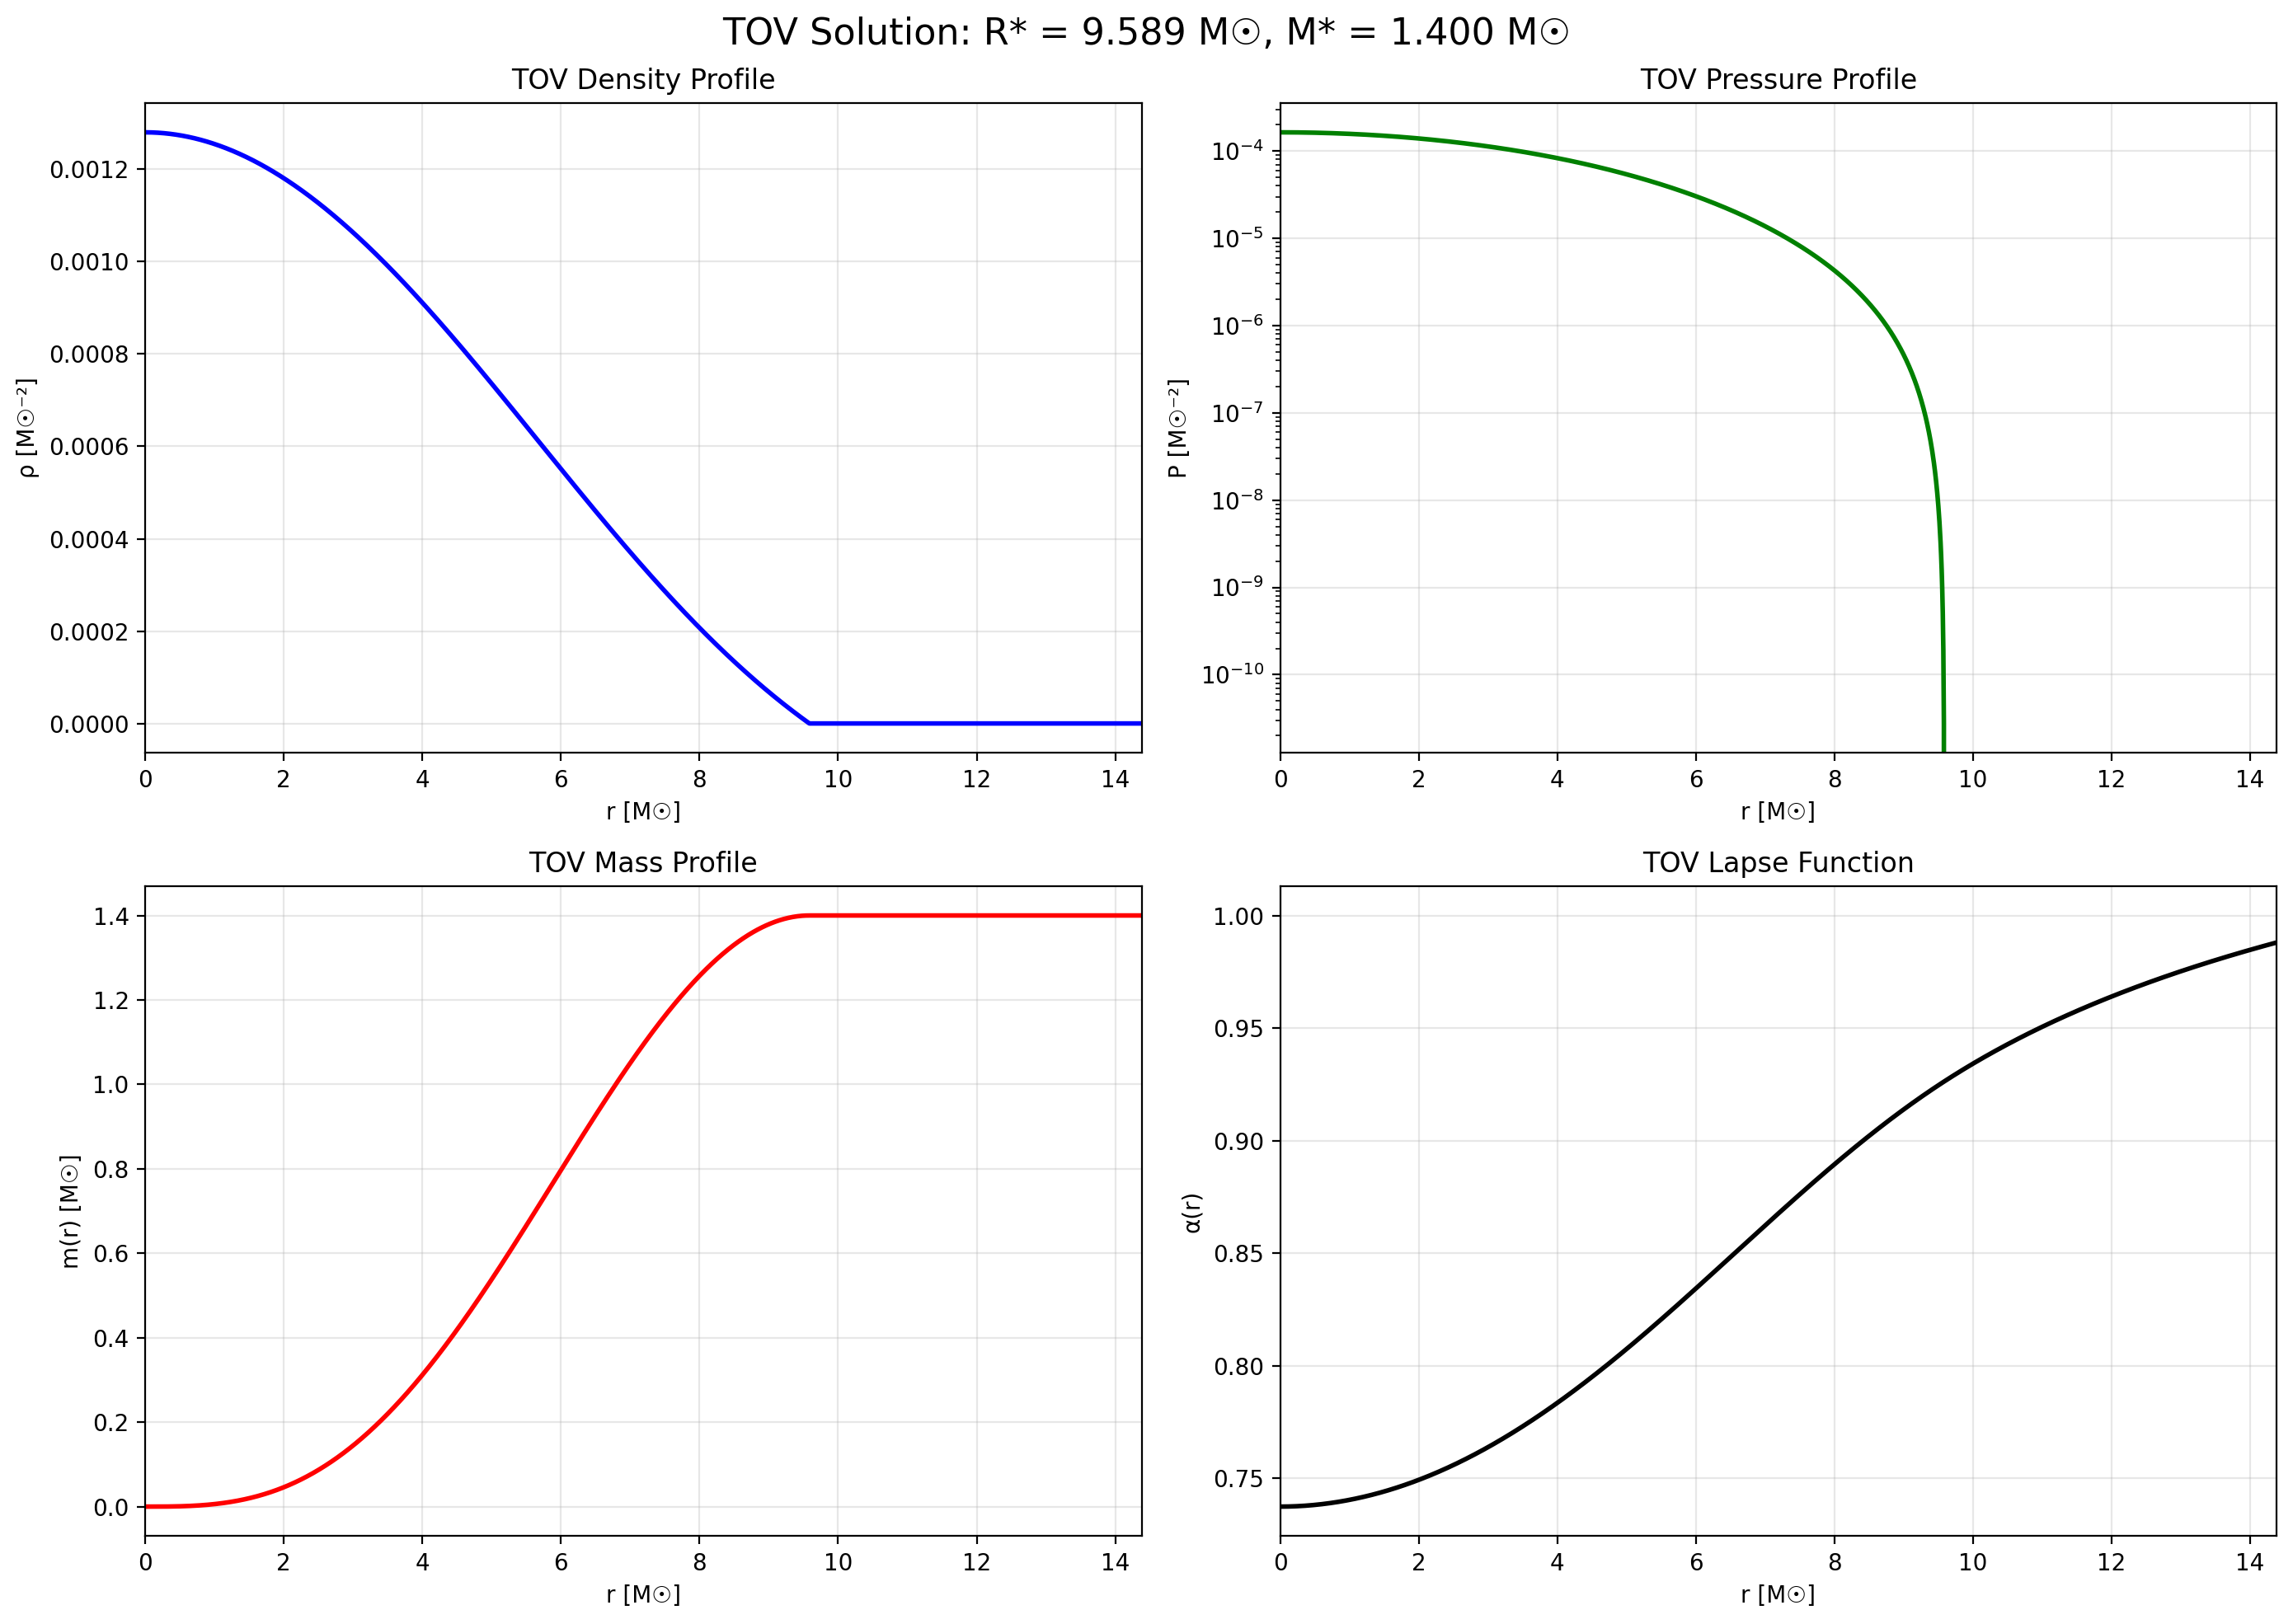

TOV Solution Summary:
  Stellar radius R* = 9.589 M☉
  Stellar mass M* = 1.400 M☉
  Central density ρc = 0.001280 M☉⁻²
  Central pressure Pc = 0.000164 M☉⁻²
  Polytropic index Γ = 2.0
  Polytropic constant K = 100.0 M☉⁻²
  Compactness M*/R* = 0.146


In [4]:
# Solve and visualize the initial TOV solution
tov_solution = solve_tov_ode(r_max=r_max, rho_central=rho_central, gamma=gamma, K=K, n_points=2000)

# Create TOV solution plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Density profile
axes[0,0].plot(tov_solution['r'], tov_solution['rho'], 'b-', lw=2)
axes[0,0].set_xlabel('r [M☉]')
axes[0,0].set_ylabel('ρ [M☉⁻²]')
axes[0,0].set_title('TOV Density Profile')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_xlim(0, min(15, tov_solution['R_star']*1.5))

# Pressure profile  
axes[0,1].semilogy(tov_solution['r'], tov_solution['pressure'], 'g-', lw=2)
axes[0,1].set_xlabel('r [M☉]')
axes[0,1].set_ylabel('P [M☉⁻²]')
axes[0,1].set_title('TOV Pressure Profile')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_xlim(0, min(15, tov_solution['R_star']*1.5))

# Mass profile
axes[1,0].plot(tov_solution['r'], tov_solution['mass'], 'r-', lw=2)
axes[1,0].set_xlabel('r [M☉]')
axes[1,0].set_ylabel('m(r) [M☉]')
axes[1,0].set_title('TOV Mass Profile')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_xlim(0, min(15, tov_solution['R_star']*1.5))

# Lapse function
axes[1,1].plot(tov_solution['r'], tov_solution['alpha'], 'k-', lw=2)
axes[1,1].set_xlabel('r [M☉]')
axes[1,1].set_ylabel('α(r)')
axes[1,1].set_title('TOV Lapse Function')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].set_xlim(0, min(15, tov_solution['R_star']*1.5))

plt.suptitle(f'TOV Solution: R* = {tov_solution["R_star"]:.3f} M☉, M* = {tov_solution["M_star"]:.3f} M☉', fontsize=16)
plt.tight_layout()
plt.show()

# Print TOV solution summary
print(f'TOV Solution Summary:')
print(f'  Stellar radius R* = {tov_solution["R_star"]:.3f} M☉')
print(f'  Stellar mass M* = {tov_solution["M_star"]:.3f} M☉')
print(f'  Central density ρc = {rho_central:.6f} M☉⁻²')
print(f'  Central pressure Pc = {K * rho_central**gamma:.6f} M☉⁻²')
print(f'  Polytropic index Γ = {gamma}')
print(f'  Polytropic constant K = {K} M☉⁻²')
print(f'  Compactness M*/R* = {tov_solution["M_star"]/tov_solution["R_star"]:.3f}')

## Engrenage Grid and Hydro Setup

In [5]:
# Spacing and grid (HALF extent, avoids r=0 in interior)
spacing = LinearSpacing(N, r_max, SpacingExtent.HALF)
r = spacing[0]

# Hydro model (polytropic EOS).
hydro = PerfectFluid(
    eos=PolytropicEOS(K=K, gamma=gamma),
    spacetime_mode='dynamic',
    atmosphere_rho=1e-15,
    reconstructor=create_reconstruction("mp5"),
    riemann_solver=HLLERiemannSolver()
)

state_vec = StateVector(hydro)
grid = Grid(spacing, state_vec)
background = FlatSphericalBackground(r)

print('Grid ready: N=', grid.N, ' r[0..3]=', r[:3])

Grid ready: N= 1600  r[0..3]= [-0.02505481 -0.01503288 -0.00501096]


## Build TOV Initial Data on the Engrenage Grid

In [6]:
# Solve TOV on a fine auxiliary grid, then interpolate to Engrenage r
tov = solve_tov_ode(r_max=r[-1], rho_central=rho_central, gamma=gamma, K=K, n_points=2000)

rho_interp = interp1d(tov['r'], tov['rho'], kind='linear', bounds_error=False, fill_value=1e-15)
p_interp   = interp1d(tov['r'], tov['pressure'], kind='linear', bounds_error=False, fill_value=1e-15)

rho0 = np.maximum(rho_interp(r), 1e-15)
pressure = np.maximum(p_interp(r), 1e-15)
vr = np.zeros_like(r)  # hydrostatic equilibrium

# Conservative variables (Valencia)
eps = hydro.eos.eps_from_rho(rho0)
h   = hydro.eos.enthalpy(rho0)
W   = 1.0
D   = np.maximum(rho0 * W, 1e-15)
Sr  = np.zeros_like(r)
tau = np.maximum(rho0 * h * W*W - pressure - D, 1e-15)

print('TOV interpolation complete. R*=%.3f, M*=%.3f, max(rho)=%.3f' % (tov['R_star'], tov['M_star'], rho0.max()))

TOV interpolation complete. R*=9.589, M*=1.400, max(rho)=0.001


## ELH Cowling Test Setup

This section implements the TOV metric setup for the ELH Cowling approximation test.

In [7]:
import numpy as np
from source.bssn.bssnstatevariables import (
    idx_phi, idx_hrr, idx_htt, idx_hpp, idx_K, idx_arr, idx_att, idx_app,
    idx_lambdar, idx_shiftr, idx_br, idx_lapse
)

def build_tov_metric_state(grid, hydro, background, r, tov, D, Sr, tau):
    state = np.zeros((grid.NUM_VARS, grid.N))
    
    # For Cowling, we use a simpler approach: conformally flat with TOV lapse
    # This avoids the determinant constraint issues while keeping the essential physics
    
    # Conformally flat: φ=0, h_ij=0 
    state[idx_phi,   :] = 0.0
    state[idx_hrr,   :] = 0.0
    state[idx_htt,   :] = 0.0
    state[idx_hpp,   :] = 0.0
    state[idx_K,     :] = 0.0
    state[idx_arr,   :] = 0.0
    state[idx_att,   :] = 0.0
    state[idx_app,   :] = 0.0
    state[idx_lambdar, :] = 0.0
    state[idx_shiftr,  :] = 0.0
    state[idx_br,      :] = 0.0
    
    # Use TOV lapse (this is the key physics for Cowling)
    a_interp = interp1d(tov['r'], tov['alpha'], kind='linear', bounds_error=False,
                        fill_value=(tov['alpha'][0], tov['alpha'][-1]))
    lapse = a_interp(r)
    state[idx_lapse,   :] = lapse

    # Add matter vars
    state[12, :] = D
    state[13, :] = Sr
    state[14, :] = tau

    # Fill boundaries (imposes parities / asymptotics)
    grid.fill_boundaries(state)

    return state

def get_metric_function_a(r, tov):
    """Compute metric function a(r) = 1/sqrt(1 - 2m/r) from TOV solution."""
    m_interp = interp1d(tov['r'], tov['mass'], kind='linear', bounds_error=False,
                        fill_value=(tov['mass'][0], tov['mass'][-1]))
    m_prof = m_interp(r)
    a_prof = np.ones_like(r)
    for i, ri in enumerate(r):
        if ri > 1e-12 and m_prof[i] > 0:
            fac = 1.0 - 2.0*m_prof[i]/ri
            a_prof[i] = 1.0/np.sqrt(fac) if fac > 1e-12 else (a_prof[i-1] if i>0 else 1.0)
    return a_prof

# Build TOV state only
state_tov = build_tov_metric_state(grid, hydro, background, r, tov, D, Sr, tau)

print('TOV Cowling state built successfully. Using conformally flat metric with TOV lapse.')

TOV Cowling state built successfully. Using conformally flat metric with TOV lapse.


In [8]:
# Hydro model used for the Cowling evolutions (reuses ELH setup)
hydro_cowling = PerfectFluid(
    eos=PolytropicEOS(K=K, gamma=gamma),
    spacetime_mode='dynamic',
    atmosphere_rho=1e-16,
    reconstructor=create_reconstruction("mp5"),
    riemann_solver=HLLERiemannSolver()
)

print('Cowling hydro configured (PerfectFluid, dynamic spacetime).')


Cowling hydro configured (PerfectFluid, dynamic spacetime).


## Evolution Utilities

In [9]:
import importlib
import source.core.rhsevolution as rhsevolution
importlib.reload(rhsevolution)
import numpy as np
import time
from math import ceil
from contextlib import suppress
from tqdm.auto import tqdm
from source.matter.hydro.cons2prim import cons_to_prim

# Bind latest get_rhs from reloaded module
get_rhs = rhsevolution.get_rhs

class Progress:
    def __init__(self, total_steps, desc='evolving'):
        self.bar = tqdm(total=int(max(1,total_steps)), desc=desc, leave=True)
        self.done = 0
    def update(self, n, t=None):
        n = int(n)
        if n > 0:
            with suppress(Exception):
                if t is not None:
                    self.bar.set_postfix_str(f't={t:.4e}')
                self.bar.update(n)
            self.done += n
    def close(self):
        with suppress(Exception):
            self.bar.close()

class Monitor:
    def __init__(self, r, idx_center=None):
        self.r = r
        self.times = []
        self.central = []
        self.idx = idx_center if idx_center is not None else NUM_GHOSTS
    def log(self, t, state_2d, hydro):
        D = state_2d[hydro.idx_D, :]
        self.times.append(t)
        self.central.append(D[self.idx])

# ============= FAST RK3 INTEGRATOR (like test.py) =============
def precompute_tov_geometry(r, tov_solution):
    """Precompute all TOV geometry functions on the grid to avoid recomputation."""
    
    # Interpolate TOV solution to grid
    alpha_interp = interp1d(tov_solution['r'], tov_solution['alpha'], 
                           kind='linear', bounds_error=False, 
                           fill_value=(tov_solution['alpha'][0], tov_solution['alpha'][-1]))
    
    mass_interp = interp1d(tov_solution['r'], tov_solution['mass'], 
                          kind='linear', bounds_error=False, 
                          fill_value=(tov_solution['mass'][0], tov_solution['mass'][-1]))
    
    # Compute metric functions on grid
    alpha = alpha_interp(r)
    mass = mass_interp(r)
    
    # Compute gamma_rr = a(r)^2 = 1/(1-2m/r)^2  
    gamma_rr = np.ones_like(r)
    for i, ri in enumerate(r):
        if ri > 1e-12 and mass[i] > 0:
            fac = 1.0 - 2.0*mass[i]/ri
            if fac > 1e-12:
                gamma_rr[i] = 1.0/fac
            else:
                gamma_rr[i] = gamma_rr[i-1] if i > 0 else 1.0
                
    # Conformal factor phi = 0 for conformally flat (as in build_tov_metric_state)
    phi = np.zeros_like(r)
    
    # Beta^r = 0 for static TOV
    beta_r = np.zeros_like(r)
    
    return {
        'alpha': alpha,
        'beta_r': beta_r, 
        'phi': phi,
        'gamma_rr': gamma_rr,
        'mass': mass
    }

def fill_ghosts_primitives(rho, v, p, W=None, h=None, ng=NUM_GHOSTS):
    """Apply boundary conditions with proper parity for primitive variables."""
    N = len(rho)

    even_fields = [rho, p]
    odd_fields = [v]
    if W is not None:
        even_fields.append(W)
    if h is not None:
        even_fields.append(h)

    for i in range(ng):
        mir = 2 * ng - 1 - i
        for arr in even_fields:
            arr[i] = arr[mir]
        for arr in odd_fields:
            arr[i] = -arr[mir]

    last = N - ng - 1
    for k in range(1, ng + 1):
        idx = last + k
        for arr in even_fields:
            arr[idx] = arr[last]
        for arr in odd_fields:
            arr[idx] = arr[last]

    return rho, v, p, W, h

def cons_to_prim_fast(D, Sr, tau, eos, metric_cache, p_guess=None):
    """Fast conservative to primitive conversion using precomputed metric."""
    result = cons_to_prim(
        {'D': D, 'Sr': Sr, 'tau': tau},
        eos,
        metric={
            'alpha': metric_cache['alpha'],
            'beta_r': metric_cache['beta_r'],
            'gamma_rr': metric_cache['gamma_rr'],
        },
        p_guess=p_guess
    )
    return result['rho0'], result['vr'], result['p'], result['W'], result['h']

def max_signal_speed_relativistic(rho0, v, p, eos, alpha, gamma_rr, cfl_guard=1e-6):
    """Compute maximum signal speed for CFL condition in curved spacetime."""
    eps = eos.eps_from_rho_p(rho0, p)
    h = 1.0 + eps + p/np.maximum(rho0, 1e-300)
    cs2 = np.clip(eos.gamma * p / np.maximum(rho0*h, 1e-300), 0.0, 1.0 - 1e-10)
    cs = np.sqrt(cs2)
    
    # Relativistic signal speed: a_max ≈ α * (|v|+c_s) / sqrt(γ_rr)
    # (for β^r=0 static case)
    a_max = alpha * (np.abs(v) + cs) / np.sqrt(gamma_rr)
    return np.max(a_max) + cfl_guard

def rk3_step_cowling(valencia, D, Sr, tau, rho0, v, p, W, h, r, grid, eos,
                    recon, rsolve, tov_geometry, bssn_vars, bssn_d1, background,
                    spacetime_mode, cfl=0.3):
    """RK3 step for Cowling evolution with precomputed TOV geometry."""

    amax = max_signal_speed_relativistic(
        rho0, v, p, eos, tov_geometry['alpha'], tov_geometry['gamma_rr']
    )
    dr_candidate = getattr(grid, 'dr', None)
    if isinstance(dr_candidate, (list, tuple, np.ndarray)):
        dr_min = float(np.min(np.abs(dr_candidate)))
    elif dr_candidate is not None:
        dr_min = float(dr_candidate)
    else:
        dr_min = float(getattr(grid, 'min_dr', r[1] - r[0]))
    dt = cfl * dr_min / amax

    rhsD, rhsSr, rhsTau = valencia.compute_rhs(
        D, Sr, tau, rho0, v, p, W, h, r, bssn_vars, bssn_d1, background,
        spacetime_mode, eos, grid, recon, rsolve
    )
    D1 = D + dt * rhsD
    Sr1 = Sr + dt * rhsSr
    tau1 = tau + dt * rhsTau
    rho1, v1, p1, W1, h1 = cons_to_prim_fast(D1, Sr1, tau1, eos, tov_geometry, p_guess=p)
    rho1, v1, p1, W1, h1 = fill_ghosts_primitives(rho1, v1, p1, W1, h1)

    rhsD, rhsSr, rhsTau = valencia.compute_rhs(
        D1, Sr1, tau1, rho1, v1, p1, W1, h1, r, bssn_vars, bssn_d1, background,
        spacetime_mode, eos, grid, recon, rsolve
    )
    D2 = 0.75 * D + 0.25 * (D1 + dt * rhsD)
    Sr2 = 0.75 * Sr + 0.25 * (Sr1 + dt * rhsSr)
    tau2 = 0.75 * tau + 0.25 * (tau1 + dt * rhsTau)
    rho2, v2, p2, W2, h2 = cons_to_prim_fast(D2, Sr2, tau2, eos, tov_geometry, p_guess=p1)
    rho2, v2, p2, W2, h2 = fill_ghosts_primitives(rho2, v2, p2, W2, h2)

    rhsD, rhsSr, rhsTau = valencia.compute_rhs(
        D2, Sr2, tau2, rho2, v2, p2, W2, h2, r, bssn_vars, bssn_d1, background,
        spacetime_mode, eos, grid, recon, rsolve
    )
    Dn = (1.0 / 3.0) * D + (2.0 / 3.0) * (D2 + dt * rhsD)
    Srn = (1.0 / 3.0) * Sr + (2.0 / 3.0) * (Sr2 + dt * rhsSr)
    taun = (1.0 / 3.0) * tau + (2.0 / 3.0) * (tau2 + dt * rhsTau)
    rhon, vn, pn, Wn, hn = cons_to_prim_fast(Dn, Srn, taun, eos, tov_geometry, p_guess=p2)
    rhon, vn, pn, Wn, hn = fill_ghosts_primitives(rhon, vn, pn, Wn, hn)

    return dt, Dn, Srn, taun, rhon, vn, pn, Wn, hn


print('Fast RK3 integrator with precomputed TOV geometry ready.')



Fast RK3 integrator with precomputed TOV geometry ready.


## Cowling Evolution (Hydro only, fixed TOV metric)

In Cowling approximation, we evolve only the matter while keeping the spacetime metric fixed. 
We use the TOV metric as the correct static background for this test.

In [10]:
# Helper Functions for ELH Paper-Style Plots (Fig. 11 & 12)

def _nearest_time_index(times, t_target):
    """Find index of time closest to target."""
    return np.argmin(np.abs(times - t_target))

def _unpack_state(y_flat, N):
    """Unpack flattened state into conservative variables."""
    # y_flat has shape (NUM_VARS * N,)
    # Reshape to (NUM_VARS, N)
    state_2d = y_flat.reshape(-1, N)
    D = state_2d[hydro_cowling.idx_D, :]
    Sr = state_2d[hydro_cowling.idx_Sr, :]  
    tau = state_2d[hydro_cowling.idx_tau, :]
    return D, Sr, tau

def _get_tov_metric():
    # Use precomputed tov_geometry if available; else flat metric
    g = globals()
    if "tov_geometry" in g:
        tg = g["tov_geometry"]
        return {"alpha": tg.get("alpha", 1.0),
                "beta_r": tg.get("beta_r", 0.0),
                "gamma_rr": tg.get("gamma_rr", 1.0)}
    # Fallback to flat metric
    return None

def _cons_to_prim_at_state(D, Sr, tau, r_grid, hydro, metric=None):
    """Convert conservative to primitive variables using hydro's cons2prim."""
    from source.matter.hydro.cons2prim import cons_to_prim
    
    # Prepare conservative variables
    U = {'D': D, 'Sr': Sr, 'tau': tau}
    
    # For Cowling approximation, use flat metric
    metric = {'alpha': np.ones_like(D), 'beta_r': np.zeros_like(D), 'gamma_rr': np.ones_like(D)}
    
    # Convert using the available function
    metric = metric or _get_tov_metric() or {'alpha': np.ones_like(D), 'beta_r': np.zeros_like(D), 'gamma_rr': np.ones_like(D)}
    result = cons_to_prim(U, hydro.eos, metric=metric)
    
    return {
        'rho0': result['rho0'],
        'vr': result['vr'], 
        'pressure': result['p']
    }

def _rho0_max_initial(state_initial, r_grid, hydro):
    """Extract maximum initial rest density."""
    D_initial = state_initial[hydro.idx_D, :]
    # Convert to primitive (simplified for static case)
    prims_0 = _cons_to_prim_at_state(
    D_initial, state_initial[hydro.idx_Sr, :], state_initial[hydro.idx_tau, :],
    r_grid, hydro, metric=_get_tov_metric()
)
    return np.max(prims_0['rho0'])

def _baryon_mass_from_D(D_profile, r_grid):
    """Calculate baryon mass M_b = 4π ∫ D r² dr."""
    # Only integrate over inner cells (exclude ghost zones)
    inner = slice(NUM_GHOSTS, -NUM_GHOSTS) if len(r_grid) > 2*NUM_GHOSTS else slice(0, len(r_grid))
    r_inner = r_grid[inner]
    D_inner = D_profile[inner]
    
    # Integrand: D * r² (factor of 4π included)
    integrand = D_inner * r_inner**2
    
    # Trapezoidal integration
    dr = r_inner[1] - r_inner[0]  # assuming uniform spacing
    M_b = 4.0 * np.pi * trapezoid(integrand, dx=dr)
    
    return M_b

def _central_density_from_prims(prims):
    """Extract central density from primitives."""
    # Use a point near the center (avoid exact r=0 issues)
    center_idx = len(prims['rho0']) // 4  # Or NUM_GHOSTS if available
    return prims['rho0'][center_idx]

print('Helper functions for ELH paper plots defined.')


Helper functions for ELH paper plots defined.


In [11]:

# Fast Cowling Evolution with RK3 Integrator

import numpy as np
import time
from tqdm.auto import tqdm
from source.bssn.bssnvars import BSSNVars, BSSNFirstDerivs
from source.bssn.bssnstatevariables import NUM_BSSN_VARS, idx_lapse
from scipy.integrate import trapezoid

def calculate_baryon_mass(D_profile, r_grid):
    """Calculate baryon mass M_b = 4*pi * integral D * r^2 dr (trapezoid)."""
    inner = slice(NUM_GHOSTS, -NUM_GHOSTS) if len(r_grid) > 2*NUM_GHOSTS else slice(0, len(r_grid))
    r_inner = r_grid[inner]
    D_inner = D_profile[inner]
    integrand = D_inner * r_inner**2
    dr = r_inner[1] - r_inner[0] if len(r_inner) > 1 else 0.0
    return 4.0*np.pi*trapezoid(integrand, dx=dr)

# Initial baryon mass (from TOV state)
M_b_initial = calculate_baryon_mass(state_tov[hydro_cowling.idx_D, :], r)
print(f'Initial baryon mass M_b = {M_b_initial:.6f} M_sun')

# Precompute TOV geometry once for fast access
print('Precomputing TOV geometry...')
tov_geometry = precompute_tov_geometry(r, tov)
print('TOV geometry precomputed successfully.')

class FastMonitor:
    def __init__(self, r, hydro, bssn_reference, idx_center=None, sample_stride=50, max_states=200):
        self.r = r
        self.hydro = hydro
        self.bssn_reference = bssn_reference.copy()
        self.times = []
        self.central_density = []
        self.baryon_mass = []
        self.states = []
        self.idx = idx_center if idx_center is not None else NUM_GHOSTS
        self.sample_counter = 0
        self.sample_stride = sample_stride
        self.max_states = max_states

    def log(self, t, D, Sr, tau):
        self.times.append(t)
        self.central_density.append(D[self.idx])
        self.baryon_mass.append(calculate_baryon_mass(D, self.r))
        self.sample_counter += 1
        if self.sample_counter % self.sample_stride == 0 and len(self.states) < self.max_states:
            state_2d = np.zeros((NUM_BSSN_VARS + self.hydro.NUM_MATTER_VARS, len(self.r)))
            state_2d[:NUM_BSSN_VARS, :] = self.bssn_reference
            state_2d[self.hydro.idx_D, :] = D
            state_2d[self.hydro.idx_Sr, :] = Sr
            state_2d[self.hydro.idx_tau, :] = tau
            self.states.append((t, state_2d.copy()))


def run_fast_cowling_evolution(D0, Sr0, tau0, rho0, v0, p0,
                              hydro, grid, background, tov_geometry, state_tov,
                              t_final=45.0, cfl=0.3, desc='Fast Cowling', wall_time_limit=None):
    """Fast Cowling evolution using RK3 integrator with precomputed geometry."""

    D, Sr, tau = D0.copy(), Sr0.copy(), tau0.copy()
    rho, v, p = rho0.copy(), v0.copy(), p0.copy()

    from source.matter.hydro.valencia_reference_metric import ValenciaReferenceMetric
    valencia = ValenciaReferenceMetric()
    recon = hydro.reconstructor
    rsolve = hydro.riemann_solver
    eos = hydro.eos
    spacetime_mode = getattr(hydro, 'spacetime_mode', 'dynamic')

    bssn_vars_static = BSSNVars(len(grid.r))
    bssn_vars_static.set_bssn_vars(state_tov[:NUM_BSSN_VARS, :])
    bssn_d1_static = BSSNFirstDerivs(len(grid.r))

    # Provide radial derivatives from TOV metric for source balance
    try:
        r_arr = grid.r
        def _fd1(arr, x):
            arr = np.asarray(arr); x = np.asarray(x)
            d = np.zeros_like(arr)
            if arr.size >= 3:
                d[1:-1] = (arr[2:] - arr[:-2]) / (x[2:] - x[:-2] + 1e-30)
                d[0]    = (arr[1] - arr[0])   / (x[1]  - x[0]   + 1e-30)
                d[-1]   = (arr[-1]-arr[-2])   / (x[-1] - x[-2]  + 1e-30)
            return d

        # Lapse derivative
        alpha_prof = state_tov[idx_lapse, :] if 'state_tov' in globals() else np.asarray(tov_geometry['alpha'])
        bssn_d1_static.lapse[:, 0] = _fd1(alpha_prof, r_arr)

        # Conformal metric and phi derivatives from state_tov
        phi_prof = state_tov[idx_phi, :]
        hrr_prof = state_tov[idx_hrr, :]
        htt_prof = state_tov[idx_htt, :]
        hpp_prof = state_tov[idx_hpp, :]

        bssn_d1_static.phi[:, 0] = _fd1(phi_prof, r_arr)
        bssn_d1_static.h_LL[:, 0, 0, 0] = _fd1(hrr_prof, r_arr)
        bssn_d1_static.h_LL[:, 1, 1, 0] = _fd1(htt_prof, r_arr)
        bssn_d1_static.h_LL[:, 2, 2, 0] = _fd1(hpp_prof, r_arr)
    except Exception:
        pass

    mon = FastMonitor(grid.r, hydro, state_tov[:NUM_BSSN_VARS, :])

    rho, v, p, W, h = cons_to_prim_fast(D, Sr, tau, eos, tov_geometry, p_guess=p)
    rho, v, p, W, h = fill_ghosts_primitives(rho, v, p, W, h)

    t = 0.0
    steps = 0
    start_time = time.time()

    pbar = tqdm(total=1000, desc=desc, leave=True)
    print(f'Starting fast RK3 evolution: t_final={t_final}, CFL={cfl}')

    try:
        while t < t_final and steps < 100000:
            mon.log(t, D, Sr, tau)

            dt, D, Sr, tau, rho, v, p, W, h = rk3_step_cowling(
                valencia, D, Sr, tau, rho, v, p, W, h, grid.r, grid, eos,
                recon, rsolve, tov_geometry, bssn_vars_static, bssn_d1_static,
                background, spacetime_mode, cfl=cfl
            )

            t += dt
            steps += 1

            if wall_time_limit is not None and (time.time() - start_time) > wall_time_limit:
                print(f"\nWall time limit reached (>{wall_time_limit}s). Stopping early at t={t:.3f}.")
                break

            pbar.set_postfix_str(f't={t:.3f}, dt={dt:.2e}')
            prog = int(min(pbar.total, round((t / max(t_final, 1e-16)) * pbar.total)))
            if prog > pbar.n:
                try:
                    pbar.update(prog - pbar.n)
                except Exception:
                    pass

            if not (np.isfinite(D).all() and np.isfinite(Sr).all() and np.isfinite(tau).all()):
                print(f'\nNaN/Inf detected at t={t:.4f}, step={steps}')
                break
    except Exception as e:
        print(f'\nEvolution failed at t={t:.4f}, step={steps}: {e}')
    finally:
        try:
            if pbar.n < pbar.total:
                pbar.update(pbar.total - pbar.n)
        except Exception:
            pass
        pbar.close()

    elapsed = time.time() - start_time
    mon.log(t, D, Sr, tau)

    print(f'\nEvolution completed:')
    print(f'  Final time: {t:.3f} M_sun')
    print(f'  Steps: {steps}')
    print(f'  Wall time: {elapsed:.1f} seconds')
    print(f'  Speed: {steps/elapsed:.1f} steps/second')
    print(f'  Avg dt: {t/steps:.2e} M_sun' if steps > 0 else '')

    return True, mon, (D, Sr, tau, rho, v, p)


print('\n=== Fast Cowling Evolution with RK3 ===')
t_final = 10.0
cfl = 0.20

success, mon_fast, final_state = run_fast_cowling_evolution(
    D, Sr, tau, rho0, vr, pressure,
    hydro_cowling, grid, background, tov_geometry, state_tov,
    t_final=t_final, cfl=cfl, desc='Fast RK3 Cowling'
)

if success:
    print(f'\n=== Results ===')
    times_fast = np.array(mon_fast.times)
    M_b_fast = np.array(mon_fast.baryon_mass)
    rho_c_fast = np.array(mon_fast.central_density)
    M_b_drift = np.abs(M_b_fast - M_b_fast[0]) / M_b_fast[0]
    max_M_b_drift = np.max(M_b_drift)
    final_M_b_drift = M_b_drift[-1]
    rho_c_rel_change = np.abs(rho_c_fast - rho_c_fast[0]) / (np.abs(rho_c_fast[0]) + 1e-300)
    max_rho_c_change = np.max(rho_c_rel_change)
    print(f'Initial M_b: {M_b_fast[0]:.6f} M_sun')
    print(f'Final M_b: {M_b_fast[-1]:.6f} M_sun')
    print(f'Max baryon mass drift: {max_M_b_drift:.2e}')
    print(f'Final baryon mass drift: {final_M_b_drift:.2e}')
    print(f'Max central density change: {max_rho_c_change:.2e}')
    times_series = times_fast
    M_b_series = M_b_fast
    rho_c_series = rho_c_fast
    sol_comp = type('obj', (object,), {'success': True, 't': times_fast, 'y': None})()
    mon_comp = mon_fast
    D_final, Sr_final, tau_final, rho0_final, v_final, p_final = final_state
    print('\nFast evolution completed successfully!')
    print('All plotting cells should work with the new data.')
else:
    print('Fast evolution failed!')

print('\n=== Ready for analysis and plotting ===')


Initial baryon mass M_b = 1.318562 M_sun
Precomputing TOV geometry...
TOV geometry precomputed successfully.

=== Fast Cowling Evolution with RK3 ===


Fast RK3 Cowling:   0%|          | 0/1000 [00:00<?, ?it/s]

Starting fast RK3 evolution: t_final=10.0, CFL=0.2


Fast RK3 Cowling: 100%|██████████| 1000/1000 [08:36<00:00,  1.94it/s, t=10.011, dt=1.57e-02]


Evolution completed:
  Final time: 10.011 M_sun
  Steps: 660
  Wall time: 516.3 seconds
  Speed: 1.3 steps/second
  Avg dt: 1.52e-02 M_sun

=== Results ===
Initial M_b: 1.318562 M_sun
Final M_b: 1.318562 M_sun
Max baryon mass drift: 1.31e-11
Final baryon mass drift: 1.31e-11
Max central density change: 8.57e-03

Fast evolution completed successfully!
All plotting cells should work with the new data.

=== Ready for analysis and plotting ===


# Analysis

In [12]:
# Check Evolution Success and Prepare Data

if sol_comp.success and len(sol_comp.t) > 1:
    print('Evolution successful! Preparing data for analysis...')
    
    # Extract data for analysis (handles legacy and fast RK3 paths)
    times_source = None
    if hasattr(sol_comp, 't') and len(sol_comp.t):
        times_source = sol_comp.t
    elif hasattr(mon_comp, 'times') and mon_comp.times:
        times_source = mon_comp.times
    elif 'times_series' in globals():
        times_source = globals()['times_series']
    elif 'times' in globals():
        times_source = globals()['times']
    else:
        raise ValueError('Time history is not available; run the evolution cell first.')
    times_series = np.array(times_source)
    
    M_b_source = None
    if hasattr(mon_comp, 'baryon_mass') and mon_comp.baryon_mass:
        M_b_source = mon_comp.baryon_mass
    elif 'M_b_series' in globals():
        M_b_source = globals()['M_b_series']
    elif 'M_b_evolution' in globals():
        M_b_source = globals()['M_b_evolution']
    if M_b_source is None:
        raise ValueError('Baryon mass history is not available; run the evolution cell first.')
    M_b_series = np.array(M_b_source)
    
    rho_c_source = None
    if hasattr(mon_comp, 'central_density') and mon_comp.central_density:
        rho_c_source = mon_comp.central_density
    elif 'rho_c_series' in globals():
        rho_c_source = globals()['rho_c_series']
    elif 'rho_c_evolution' in globals():
        rho_c_source = globals()['rho_c_evolution']
    if rho_c_source is None:
        raise ValueError('Central density history is not available; run the evolution cell first.')
    rho_c_series = np.array(rho_c_source)
    
    # Get initial max density for normalization
    rho0_max_0 = _rho0_max_initial(state_tov, r, hydro_cowling)
    
    # Prepare final state data
    if getattr(sol_comp, 'y', None) is not None:
        y_final = sol_comp.y[:, -1]
        D_final, Sr_final, tau_final = _unpack_state(y_final, len(r))
        prims_final = _cons_to_prim_at_state(D_final, Sr_final, tau_final, r, hydro_cowling)
        rho0_final = prims_final['rho0']
    elif 'final_state' in globals():
        D_final, Sr_final, tau_final, rho0_final, v_final, p_final = final_state
        prims_final = {'rho0': rho0_final, 'vr': v_final, 'pressure': p_final}
    else:
        raise ValueError('Final evolution state is not available; run the evolution cell first.')
    
    # Baryon mass conservation metrics
    M0 = M_b_series[0]
    deltaM = np.abs(M_b_series - M0)
    deltaM = np.maximum(deltaM, 1e-300)  # for log10
    
    # Central density relative change
    rho_c_rel = rho_c_series / (rho0_max_0 + 1e-300) - 1.0
    
    print(f'Data prepared for {len(times_series)} time steps')
    print(f'Final time: {times_series[-1]:.2f} M☉')
    print('Ready for plotting...')
    
else:
    print('Evolution failed or too short. Check parameters.')
    if hasattr(sol_comp, 'message'):
        print(f'Error: {sol_comp.message}')



Evolution successful! Preparing data for analysis...
Data prepared for 661 time steps
Final time: 10.01 M☉
Ready for plotting...


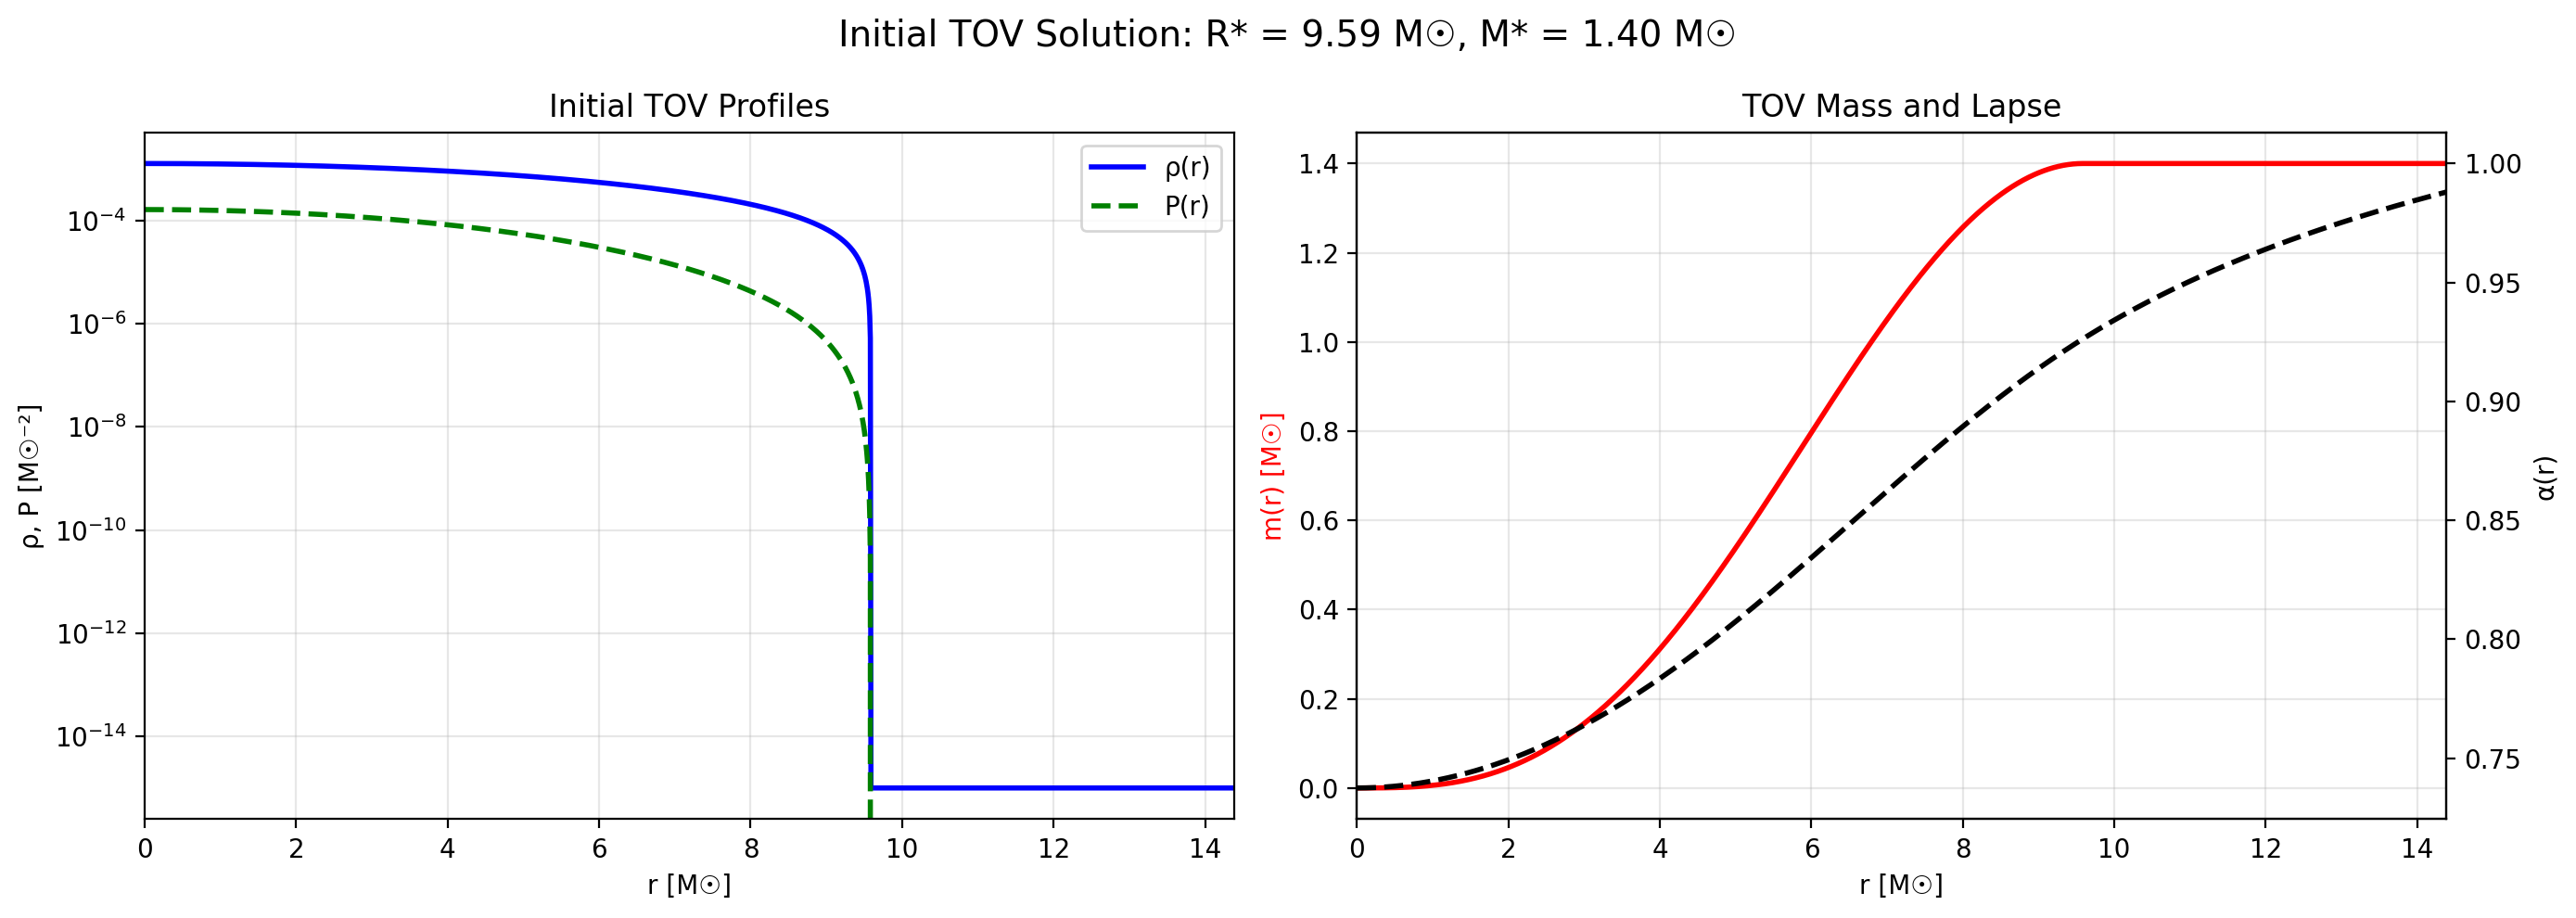

TOV parameters: R* = 9.589 M☉, M* = 1.400 M☉
Compactness: M*/R* = 0.146


In [13]:
# Plot 1: Initial TOV Profiles

if sol_comp.success:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # TOV density and pressure
    ax1.semilogy(tov['r'], tov['rho'], 'b-', lw=2, label='ρ(r)')
    ax1.semilogy(tov['r'], tov['pressure'], 'g--', lw=2, label='P(r)')
    ax1.set_xlabel('r [M☉]')
    ax1.set_ylabel('ρ, P [M☉⁻²]')
    ax1.set_title('Initial TOV Profiles')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_xlim(0, min(15, tov['R_star']*1.5))
    
    # TOV mass and lapse
    ax2.plot(tov['r'], tov['mass'], 'r-', lw=2, label='m(r)')
    ax2_twin = ax2.twinx()
    ax2_twin.plot(tov['r'], tov['alpha'], 'k--', lw=2, label='α(r)')
    ax2.set_xlabel('r [M☉]')
    ax2.set_ylabel('m(r) [M☉]', color='r')
    ax2_twin.set_ylabel('α(r)', color='k')
    ax2.set_title('TOV Mass and Lapse')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, min(15, tov['R_star']*1.5))
    
    plt.suptitle(f'Initial TOV Solution: R* = {tov["R_star"]:.2f} M☉, M* = {tov["M_star"]:.2f} M☉', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print(f'TOV parameters: R* = {tov["R_star"]:.3f} M☉, M* = {tov["M_star"]:.3f} M☉')
    print(f'Compactness: M*/R* = {tov["M_star"]/tov["R_star"]:.3f}')

In [14]:
# Deprecated: consolidated into ESSENTIAL ANALYSIS


In [15]:
# Deprecated: consolidated into ESSENTIAL ANALYSIS


In [16]:
# Deprecated: consolidated into ESSENTIAL ANALYSIS


In [17]:
# Deprecated: consolidated into ESSENTIAL ANALYSIS


/tmp/ipykernel_95661/4093129190.py:94: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()


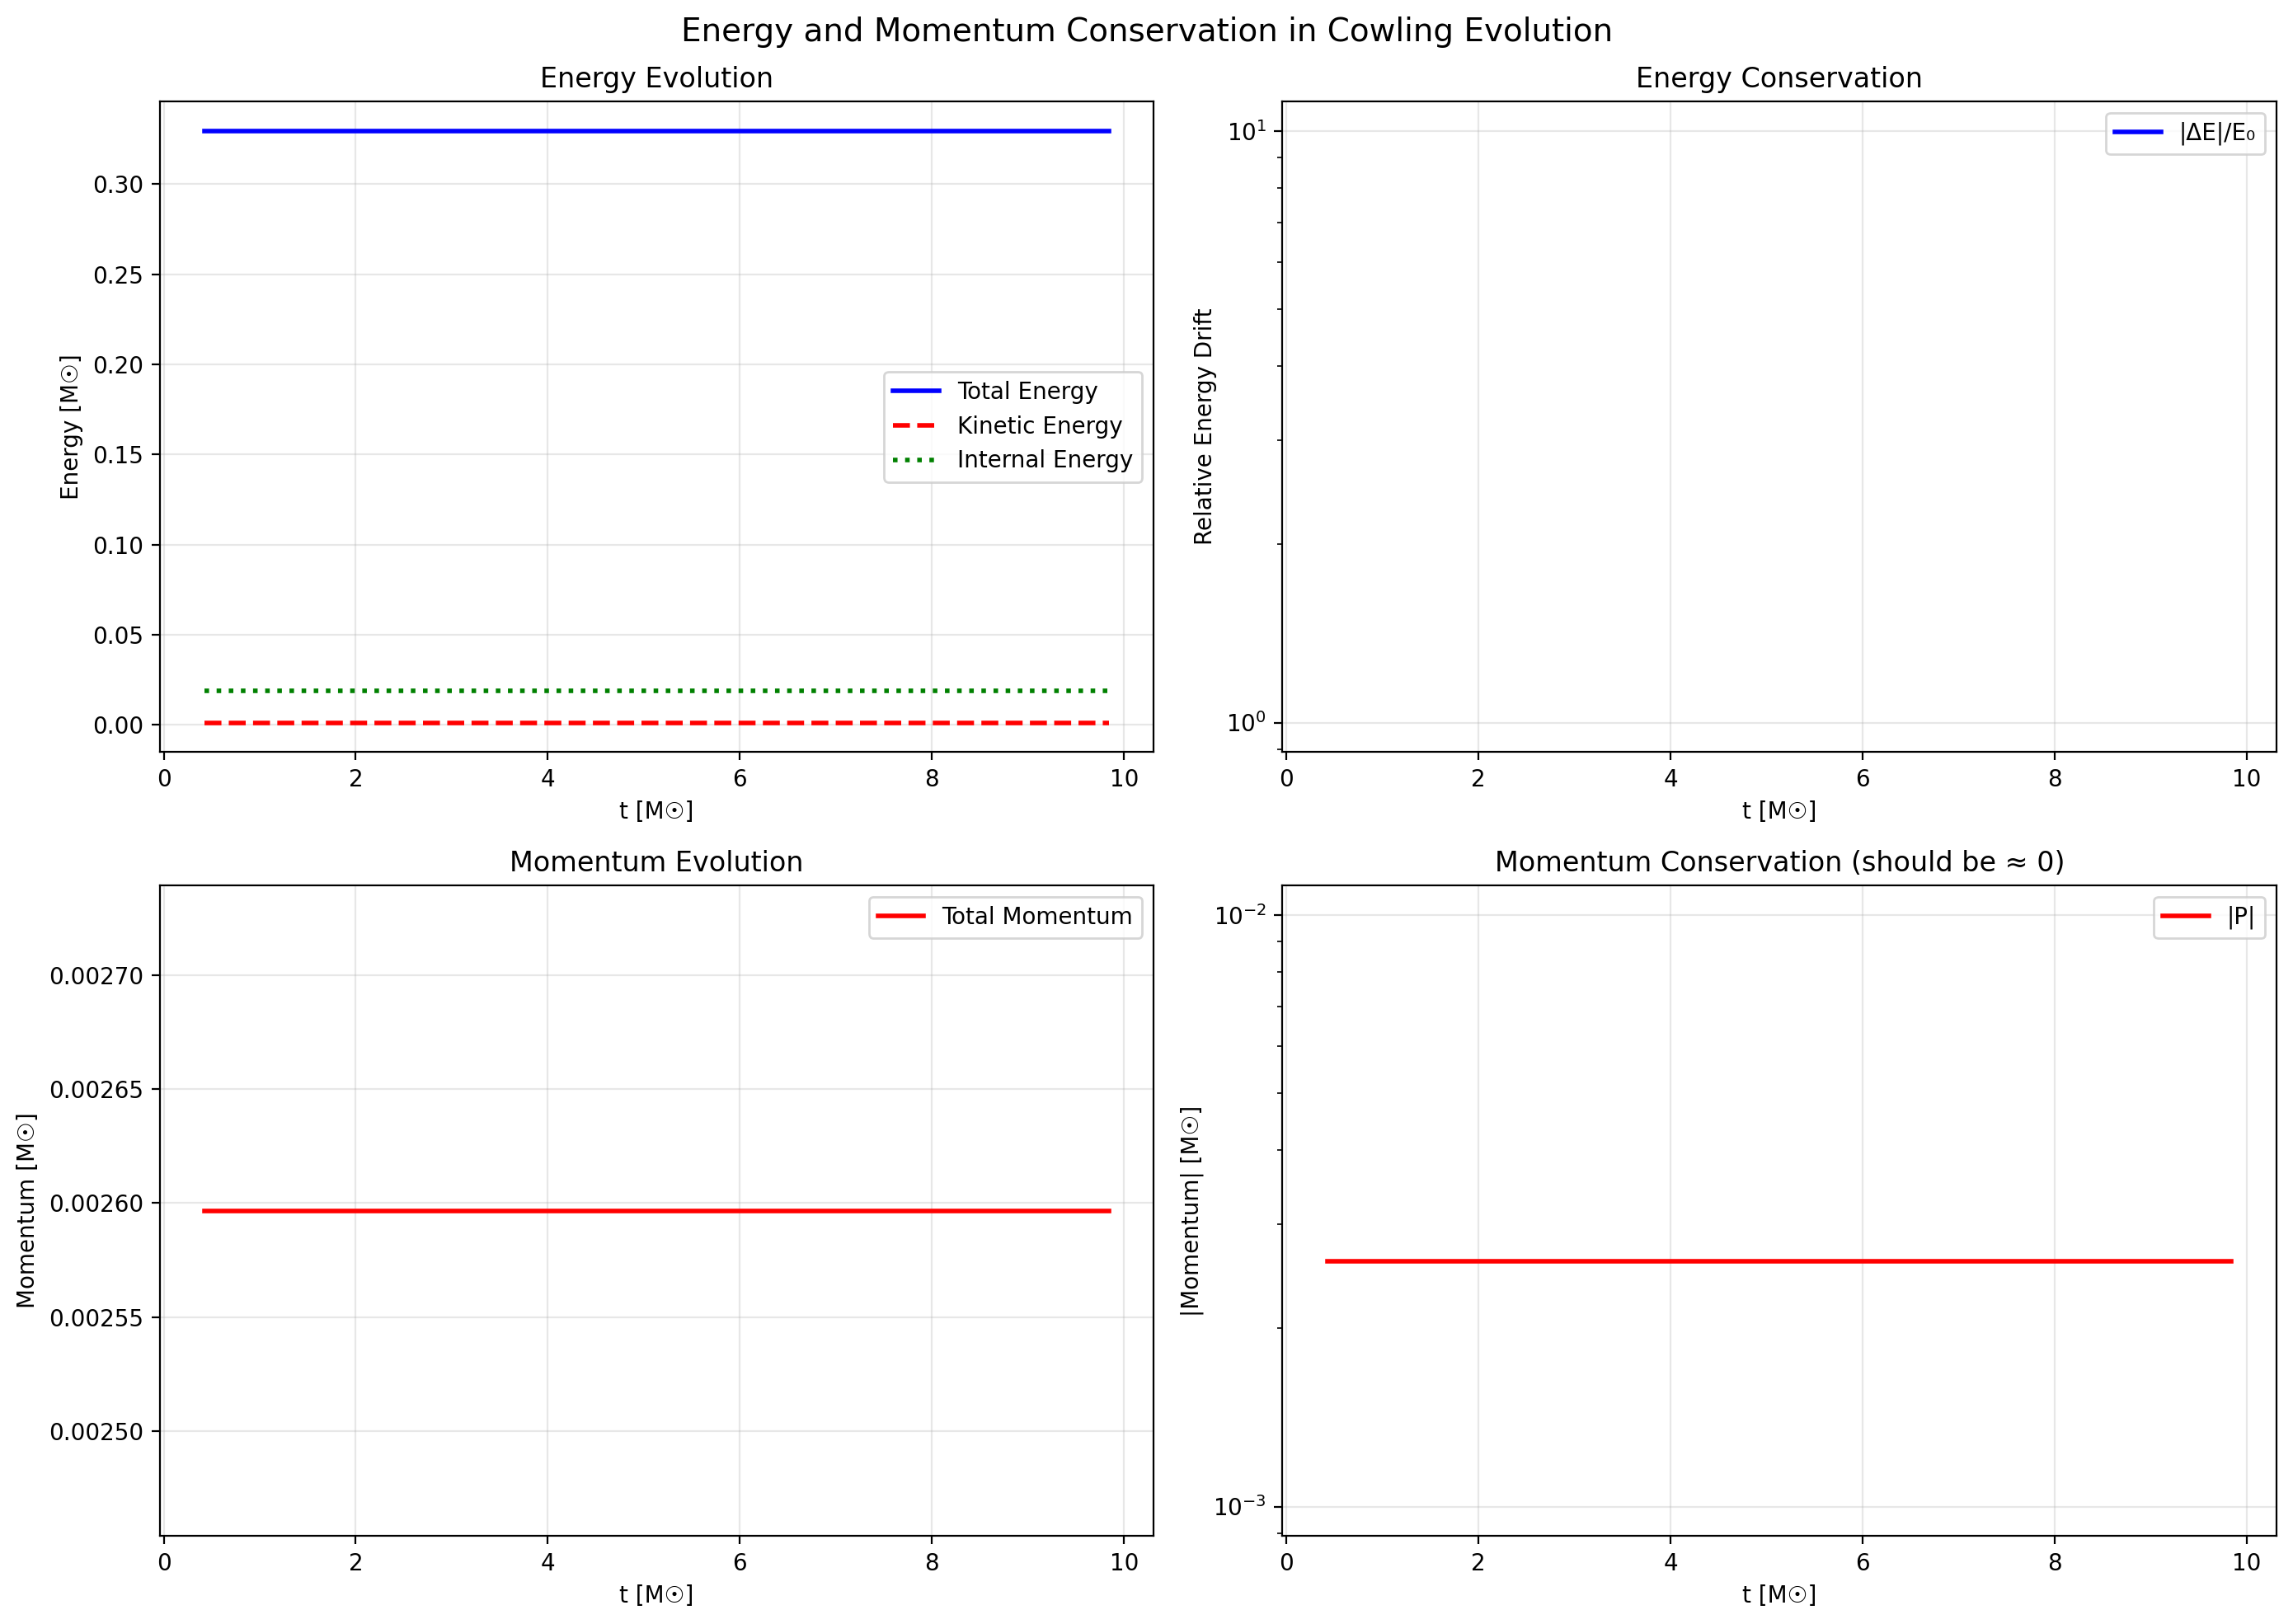

Energy-momentum analysis:
  Initial total energy: 0.329576 M☉
  Final energy drift: 0.00e+00
  Max momentum: 2.60e-03 M☉ (should be ≈ 0)
  Kinetic/Internal energy ratio: 7.07e-02


In [18]:
# Energy and Momentum Conservation Analysis

if sol_comp.success:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Calculate energy and momentum integrals over time
    total_energy = []
    total_momentum = []
    kinetic_energy = []
    internal_energy = []
    
    for i, (t, state_2d) in enumerate(mon_comp.states):
        D_t = state_2d[hydro_cowling.idx_D, :]
        Sr_t = state_2d[hydro_cowling.idx_Sr, :]
        tau_t = state_2d[hydro_cowling.idx_tau, :]
        
        prims_t = _cons_to_prim_at_state(D_t, Sr_t, tau_t, r, hydro_cowling)
        
        # Energy and momentum densities
        rho_t = prims_t['rho0']
        v_t = prims_t['vr']
        p_t = prims_t['pressure']
        
        # Lorentz factor and specific energy
        gamma_v = 1.0 / np.sqrt(1.0 - v_t**2)
        eps_t = hydro_cowling.eos.eps_from_rho_p(rho_t, p_t)
        
        # Integrate over volume (4π∫ dr r²)
        inner = slice(NUM_GHOSTS, -NUM_GHOSTS) if len(r) > 2*NUM_GHOSTS else slice(0, len(r))
        r_inner = r[inner]
        dr = r_inner[1] - r_inner[0]
        
        # Total energy (rest mass + internal + kinetic)
        E_rest = trapezoid(rho_t[inner] * r_inner**2, dx=dr) * 4*np.pi
        E_internal = trapezoid(rho_t[inner] * eps_t[inner] * r_inner**2, dx=dr) * 4*np.pi  
        E_kinetic = trapezoid(rho_t[inner] * (gamma_v[inner] - 1) * r_inner**2, dx=dr) * 4*np.pi
        E_total = E_rest + E_internal + E_kinetic
        
        # Total momentum
        P_total = trapezoid(rho_t[inner] * gamma_v[inner] * v_t[inner] * r_inner**2, dx=dr) * 4*np.pi
        
        total_energy.append(E_total)
        kinetic_energy.append(E_kinetic)
        internal_energy.append(E_internal)
        total_momentum.append(P_total)
    
    times_energy = [t for t, _ in mon_comp.states]
    total_energy = np.array(total_energy)
    kinetic_energy = np.array(kinetic_energy)
    internal_energy = np.array(internal_energy)
    total_momentum = np.array(total_momentum)
    
    # Plot energy evolution
    ax1 = axes[0,0]
    ax1.plot(times_energy, total_energy, 'b-', lw=2, label='Total Energy')
    ax1.plot(times_energy, kinetic_energy, 'r--', lw=2, label='Kinetic Energy')
    ax1.plot(times_energy, internal_energy, 'g:', lw=2, label='Internal Energy')
    ax1.set_xlabel('t [M☉]')
    ax1.set_ylabel('Energy [M☉]')
    ax1.set_title('Energy Evolution')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot energy conservation
    ax2 = axes[0,1]
    E_drift = np.abs(total_energy - total_energy[0]) / total_energy[0]
    ax2.semilogy(times_energy, E_drift, 'b-', lw=2, label='|ΔE|/E₀')
    ax2.set_xlabel('t [M☉]')
    ax2.set_ylabel('Relative Energy Drift')
    ax2.set_title('Energy Conservation')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Plot momentum evolution
    ax3 = axes[1,0]
    ax3.plot(times_energy, total_momentum, 'r-', lw=2, label='Total Momentum')
    ax3.set_xlabel('t [M☉]')
    ax3.set_ylabel('Momentum [M☉]')
    ax3.set_title('Momentum Evolution')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # Plot momentum conservation
    ax4 = axes[1,1]
    P_abs = np.abs(total_momentum)
    ax4.semilogy(times_energy, P_abs, 'r-', lw=2, label='|P|')
    ax4.set_xlabel('t [M☉]')
    ax4.set_ylabel('|Momentum| [M☉]')
    ax4.set_title('Momentum Conservation (should be ≈ 0)')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    plt.suptitle('Energy and Momentum Conservation in Cowling Evolution', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print(f'Energy-momentum analysis:')
    print(f'  Initial total energy: {total_energy[0]:.6f} M☉')
    print(f'  Final energy drift: {E_drift[-1]:.2e}')
    print(f'  Max momentum: {np.max(P_abs):.2e} M☉ (should be ≈ 0)')
    print(f'  Kinetic/Internal energy ratio: {kinetic_energy[-1]/internal_energy[-1]:.2e}')


In [19]:
# Deprecated: consolidated into ESSENTIAL ANALYSIS


In [20]:
# Deprecated: consolidated into ESSENTIAL ANALYSIS


In [21]:
# Deprecated: consolidated into ESSENTIAL ANALYSIS


# Essencial Analysis


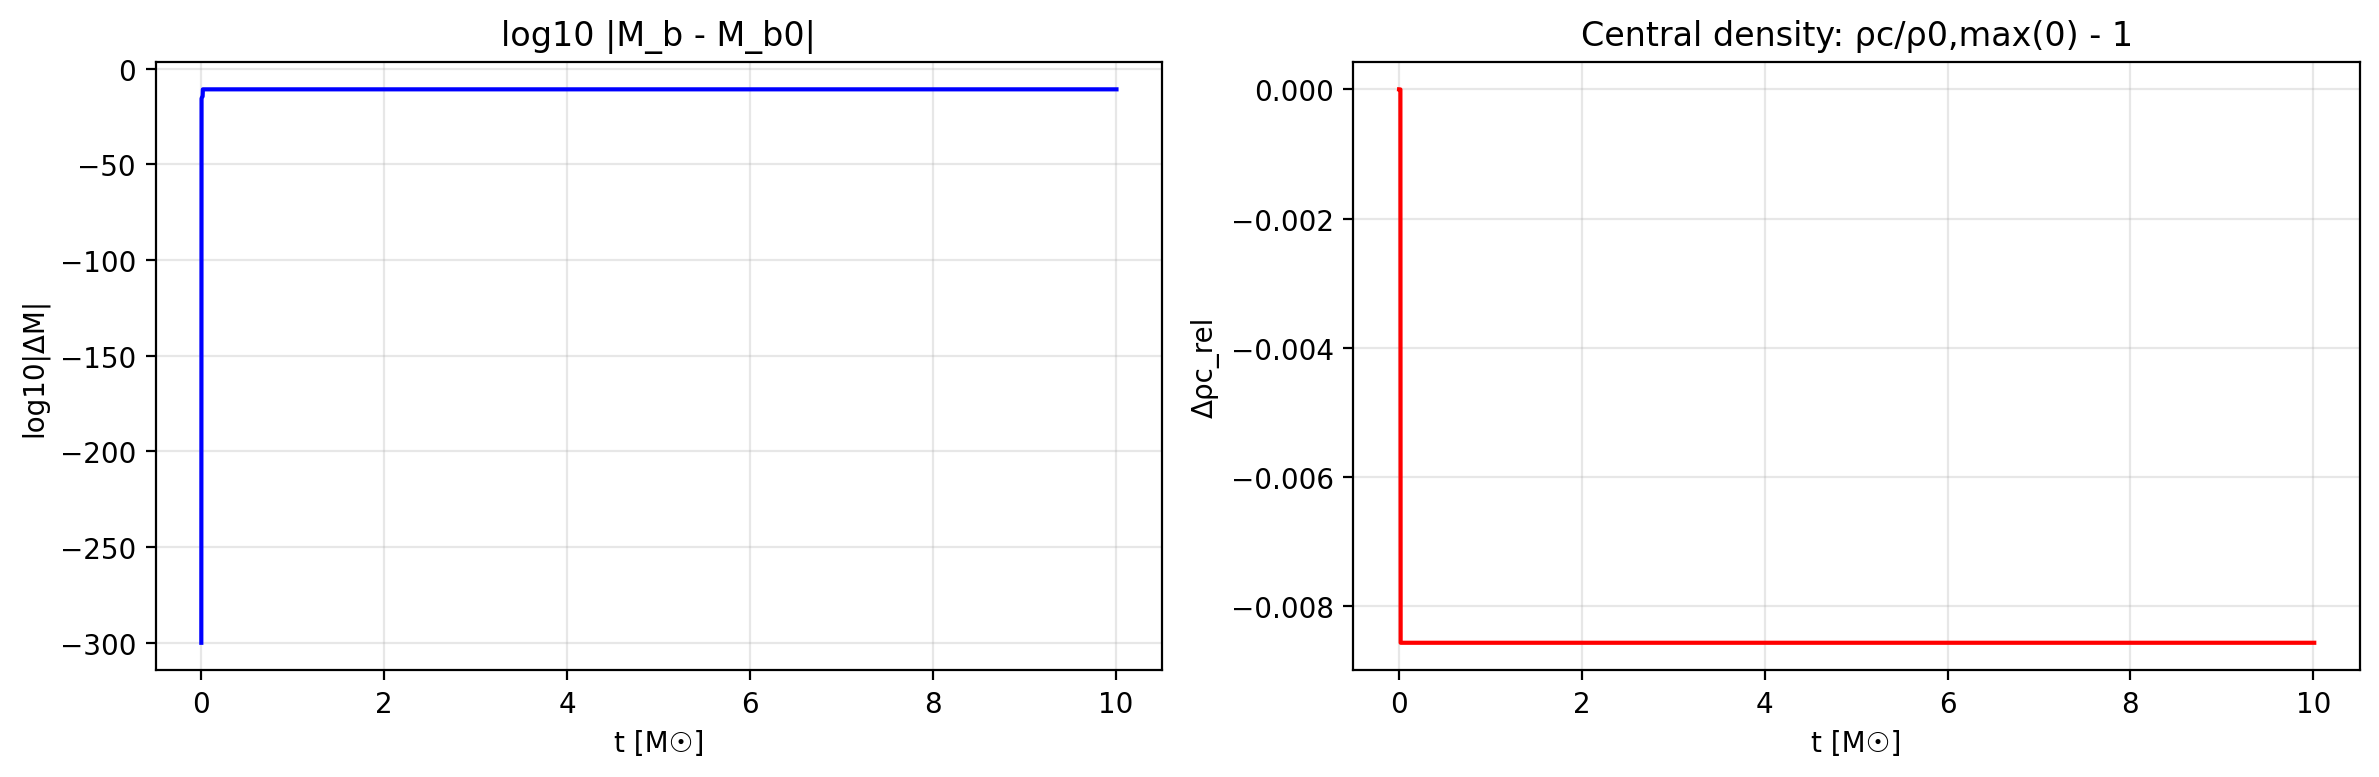

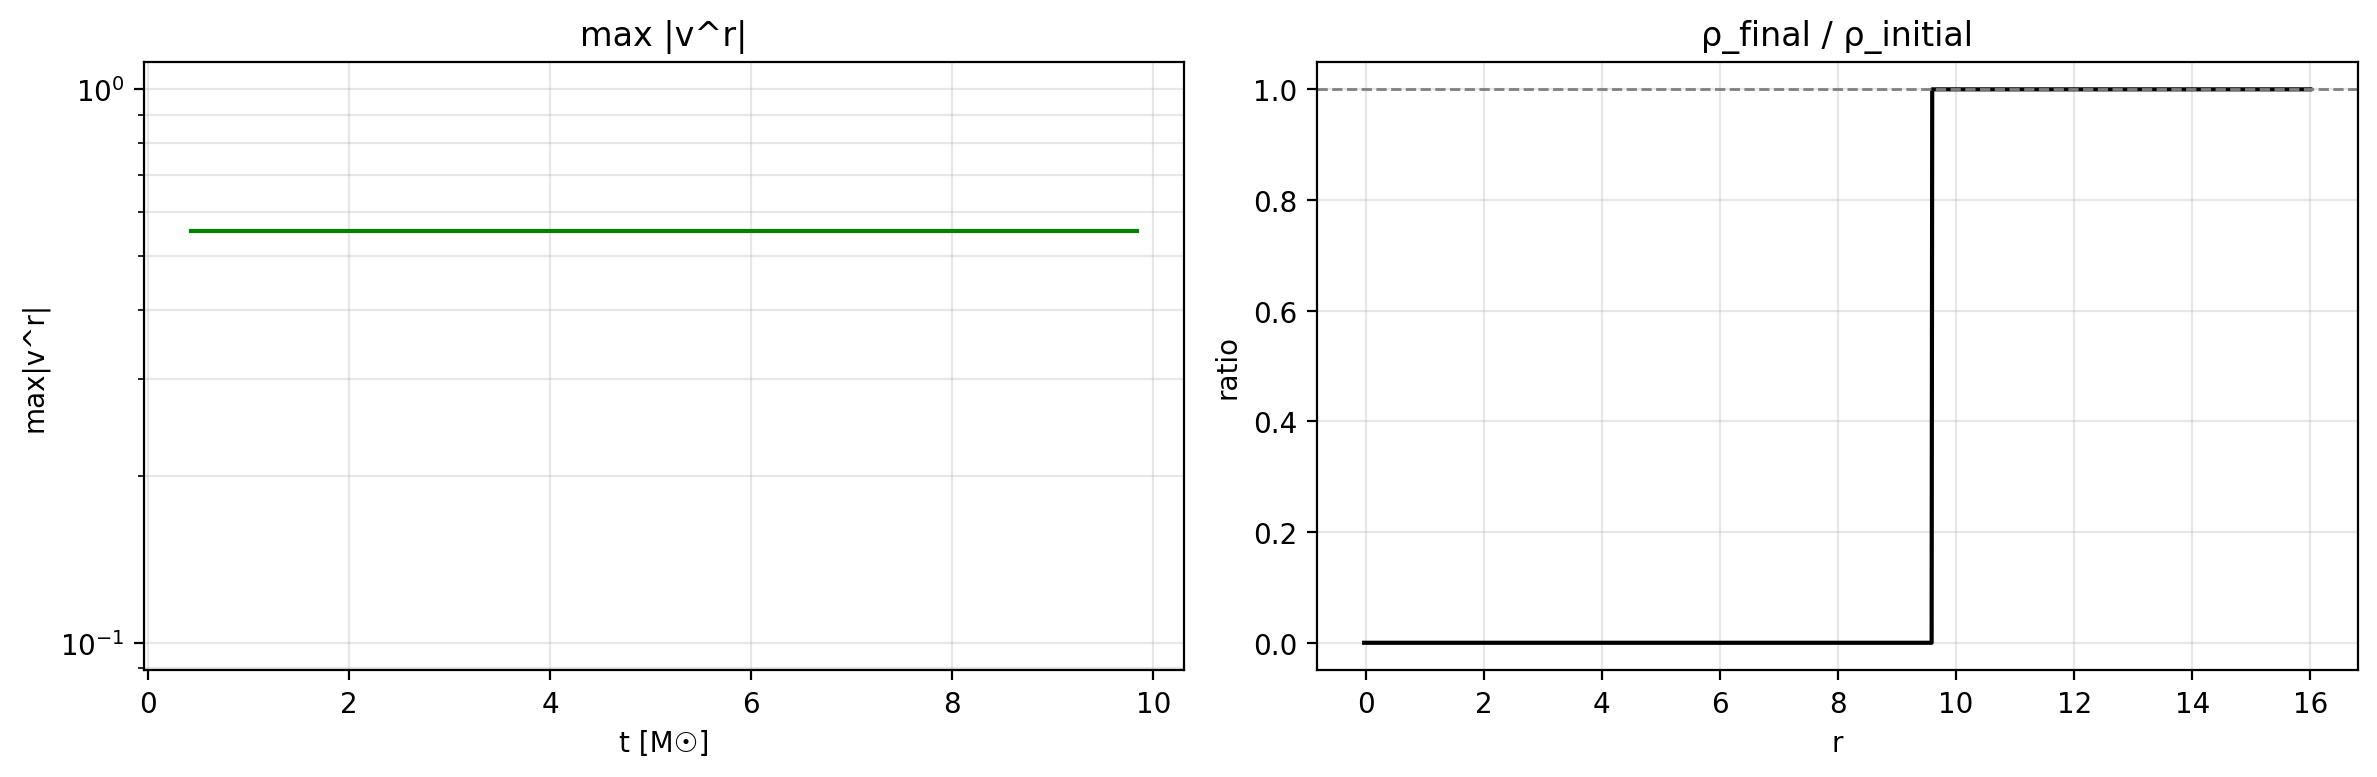

Cowling metric invariance:
  max|Δα|=0.000e+00, max|Δhij|=0.000e+00, max|Δφ|=0.000e+00, max|ΔK|=0.000e+00
Assessment:
  M_b drift (final rel): 1.31e-11  -> PASS
  max|ρc/ρ0,max(0)-1|  : 8.57e-03 -> WARN
  max|v^r|             : 5.55e-01 -> FAIL
  Cowling invariance Δ : 0.00e+00 -> PASS
RHS ||·||_inf (initial): D=2.106e-08, Sr=1.310e+06, tau=4.578e-09
RHS ||·||_inf (final): D=3.526e-02, Sr=5.430e+53, tau=1.045e+48


In [22]:

# === ESSENTIAL ANALYSIS (TOV Cowling) ===
import numpy as np
import matplotlib.pyplot as plt
from source.bssn.bssnstatevariables import (
    idx_lapse, idx_hrr, idx_htt, idx_hpp, idx_phi, idx_K, NUM_BSSN_VARS
)
from source.bssn.bssnvars import BSSNVars, BSSNFirstDerivs
from source.matter.hydro.valencia_reference_metric import ValenciaReferenceMetric
from source.matter.hydro.cons2prim import cons_to_prim

def _metric_TOV():
    g = globals()
    if 'tov_geometry' in g:
        tg = g['tov_geometry']
        return { 'alpha': tg.get('alpha', 1.0),
                 'beta_r': tg.get('beta_r', 0.0),
                 'gamma_rr': tg.get('gamma_rr', 1.0) }
    return { 'alpha': np.ones_like(r), 'beta_r': np.zeros_like(r), 'gamma_rr': np.ones_like(r) }

def _get_times_Mb_rho_c():
    g = globals()
    # times
    if 'sol_comp' in g and hasattr(g['sol_comp'], 't') and len(g['sol_comp'].t):
        times = np.array(g['sol_comp'].t)
    elif 'mon_comp' in g and hasattr(g['mon_comp'], 'times') and g['mon_comp'].times:
        times = np.array(g['mon_comp'].times)
    elif 'times_series' in g:
        times = np.array(g['times_series'])
    else:
        times = np.array([])
    # baryon mass
    if 'mon_comp' in g and hasattr(g['mon_comp'], 'baryon_mass') and g['mon_comp'].baryon_mass:
        Mb = np.array(g['mon_comp'].baryon_mass)
    elif 'M_b_series' in g:
        Mb = np.array(g['M_b_series'])
    else:
        Mb = np.array([])
    return times, Mb

def _cons_to_prim(D, Sr, tau):
    met = _metric_TOV()
    res = cons_to_prim({'D': D, 'Sr': Sr, 'tau': tau}, hydro_cowling.eos, metric=met)
    return res

def _extract_D_Sr_tau(state_2d):
    return state_2d[hydro_cowling.idx_D, :], state_2d[hydro_cowling.idx_Sr, :], state_2d[hydro_cowling.idx_tau, :]

def _rho0_max_initial():
    D0, Sr0, tau0 = _extract_D_Sr_tau(state_tov)
    prims0 = _cons_to_prim(D0, Sr0, tau0)
    return float(np.max(prims0['rho0']))

def _rhs_inf_norm(state_2d, label='state'):
    try:
        val = ValenciaReferenceMetric()
        bssn = BSSNVars(len(r)); bssn.set_bssn_vars(state_2d[:NUM_BSSN_VARS, :])
        b1 = BSSNFirstDerivs(len(r))
        # Provide lapse derivative from TOV metric so sources are balanced in Cowling
        try:
            # Finite-difference helper
            def _fd1(arr, x):
                arr = np.asarray(arr); x = np.asarray(x)
                d = np.zeros_like(arr)
                if arr.size >= 3:
                    d[1:-1] = (arr[2:] - arr[:-2]) / (x[2:] - x[:-2] + 1e-30)
                    d[0]    = (arr[1] - arr[0])   / (x[1]  - x[0]   + 1e-30)
                    d[-1]   = (arr[-1]-arr[-2])   / (x[-1] - x[-2]  + 1e-30)
                return d

            # Lapse derivative from TOV metric
            met = _metric_TOV(); alpha_prof = np.asarray(met['alpha'])
            b1.lapse[:, 0] = _fd1(alpha_prof, r)

            # Derivatives of BSSN conformal variables from state_tov
            phi_prof = np.asarray(state_tov[idx_phi, :])
            hrr_prof = np.asarray(state_tov[idx_hrr, :])
            htt_prof = np.asarray(state_tov[idx_htt, :])
            hpp_prof = np.asarray(state_tov[idx_hpp, :])

            dphi = _fd1(phi_prof, r)
            dhrr = _fd1(hrr_prof, r)
            dhtt = _fd1(htt_prof, r)
            dhpp = _fd1(hpp_prof, r)

            b1.phi[:, 0] = dphi
            b1.h_LL[:, 0, 0, 0] = dhrr
            b1.h_LL[:, 1, 1, 0] = dhtt
            b1.h_LL[:, 2, 2, 0] = dhpp
        except Exception:
            pass
        D, Sr, tau = _extract_D_Sr_tau(state_2d)
        prims = _cons_to_prim(D, Sr, tau)
        rhsD, rhsSr, rhsTau = val.compute_rhs(D, Sr, tau, prims['rho0'], prims['vr'], prims['p'], prims['W'], prims['h'],
                                              r, bssn, b1, background, 'dynamic',
                                              hydro_cowling.eos, grid, hydro_cowling.reconstructor, hydro_cowling.riemann_solver)
        inner = slice(NUM_GHOSTS, -NUM_GHOSTS) if len(r) > 2*NUM_GHOSTS else slice(0, len(r))
        infs = (np.max(np.abs(rhsD[inner])), np.max(np.abs(rhsSr[inner])), np.max(np.abs(rhsTau[inner])))
        print(f'RHS ||·||_inf ({label}): D={infs[0]:.3e}, Sr={infs[1]:.3e}, tau={infs[2]:.3e}')
    except Exception as e:
        print(f'RHS check failed ({label}): {e}')

# Gather series
times, Mb_series = _get_times_Mb_rho_c()
rho0_max0 = _rho0_max_initial()

# Prepare final primitives
if 'final_state' in globals():
    Df, Srf, tauf, rho0f, vrf, pf = final_state
    final_prims = {'rho0': rho0f, 'vr': vrf, 'p': pf}
else:
    # from integrator result
    if 'sol_comp' in globals() and getattr(sol_comp, 'y', None) is not None and sol_comp.y is not None and len(sol_comp.y.shape) == 2:
        y_final = sol_comp.y[:, -1].reshape(-1, len(r))
        Df, Srf, tauf = _extract_D_Sr_tau(y_final)
        final_prims = _cons_to_prim(Df, Srf, tauf)
    else:
        Df, Srf, tauf = _extract_D_Sr_tau(state_tov)
        final_prims = _cons_to_prim(Df, Srf, tauf)

# Mass drift (absolute and relative)
if Mb_series.size >= 1 and times.size == Mb_series.size:
    M0 = Mb_series[0]
    dM_abs = np.abs(Mb_series - M0)
    dM_rel = dM_abs / (np.abs(M0) + 1e-300)
else:
    M0 = np.nan
    dM_abs = np.array([])
    dM_rel = np.array([])

# Central density series (prefer direct monitor series if available)
center_idx = int(np.argmin(np.abs(r)))  # robust center index
rhoc_rel = np.array([])
times_rhoc = np.array([])
if 'mon_comp' in globals():
    if getattr(mon_comp, 'central_density', None) and mon_comp.central_density:
        cd = np.array(mon_comp.central_density, dtype=float)
        tms = np.array(mon_comp.times, dtype=float)
        if cd.size > 0 and np.isfinite(cd[0]) and abs(cd[0]) > 0:
            times_rhoc = tms
            rhoc_rel = cd / cd[0] - 1.0
    elif getattr(mon_comp, 'states', None):
        t_r, rho_r = [], []
        for t_snap, st in mon_comp.states:
            D_t, Sr_t, tau_t = _extract_D_Sr_tau(st)
            prims_t = _cons_to_prim(D_t, Sr_t, tau_t)
            t_r.append(t_snap)
            rho_r.append(prims_t['rho0'][center_idx])
        if rho_r:
            times_rhoc = np.array(t_r)
            rhoc_rel = np.array(rho_r)/rho0_max0 - 1.0

# Figure 1: Mass drift and central density
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
if times.size and dM_abs.size:
    ax1.plot(times, np.log10(np.maximum(dM_abs, 1e-300)), 'b-')
    ax1.set_title('log10 |M_b - M_b0|')
    ax1.set_xlabel('t [M☉]'); ax1.set_ylabel('log10|ΔM|'); ax1.grid(True, alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'No M_b series', ha='center'); ax1.axis('off')

if times_rhoc.size and rhoc_rel.size:
    ax2.plot(times_rhoc, rhoc_rel, 'r-')
    ax2.set_title('Central density: ρc/ρ0,max(0) - 1')
    ax2.set_xlabel('t [M☉]'); ax2.set_ylabel('Δρc_rel'); ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'No ρc series', ha='center'); ax2.axis('off')
plt.tight_layout(); plt.show()

# Figure 2: v^r max over time, and final density ratio vs initial
fig, (bx1, bx2) = plt.subplots(1, 2, figsize=(12, 4))

# v^r max over stored snapshots and build if missing
vr_max = []
t_shots = []
if 'mon_comp' in globals() and getattr(mon_comp, 'states', None):
    for t_snap, st in mon_comp.states:
        D_t, Sr_t, tau_t = _extract_D_Sr_tau(st)
        prims_t = _cons_to_prim(D_t, Sr_t, tau_t)
        vr_max.append(np.max(np.abs(prims_t['vr'])))
        t_shots.append(t_snap)
if vr_max:
    bx1.semilogy(t_shots, vr_max, 'g-')
    bx1.set_title('max |v^r|'); bx1.set_xlabel('t [M☉]'); bx1.set_ylabel('max|v^r|'); bx1.grid(True, which='both', alpha=0.3)
else:
    bx1.text(0.5,0.5,'No snapshots',ha='center'); bx1.axis('off')

# Density ratio final/initial
prims_initial = _cons_to_prim(*_extract_D_Sr_tau(state_tov))
ratio = final_prims['rho0'] / np.maximum(prims_initial['rho0'], 1e-300)
bx2.plot(r, ratio, 'k-')
bx2.axhline(1.0, ls='--', c='gray', lw=1)
bx2.set_title('ρ_final / ρ_initial'); bx2.set_xlabel('r'); bx2.set_ylabel('ratio'); bx2.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# Cowling invariance check (metric should not change)
if 'mon_comp' in globals() and getattr(mon_comp, 'states', None):
    _, stf = mon_comp.states[-1]
    lapse_change = float(np.max(np.abs(stf[idx_lapse,:] - state_tov[idx_lapse,:])))
    hij_max = float(max(np.max(np.abs(stf[idx_hrr,:])), np.max(np.abs(stf[idx_htt,:])), np.max(np.abs(stf[idx_hpp,:]))))
    phi_change = float(np.max(np.abs(stf[idx_phi,:] - state_tov[idx_phi,:])))
    K_change = float(np.max(np.abs(stf[idx_K,:] - state_tov[idx_K,:])))
else:
    lapse_change = hij_max = phi_change = K_change = float('nan')

print('Cowling metric invariance:')
print(f'  max|Δα|={lapse_change:.3e}, max|Δhij|={hij_max:.3e}, max|Δφ|={phi_change:.3e}, max|ΔK|={K_change:.3e}')

# Simple PASS/WARN/FAIL assessment
def assess(val, pass_thr, warn_thr):
    if not np.isfinite(val):
        return 'n/a'
    return 'PASS' if val < pass_thr else ('WARN' if val < warn_thr else 'FAIL')

final_rel = float(dM_rel[-1]) if dM_rel.size else float('nan')
max_rhoc = float(np.max(np.abs(rhoc_rel))) if rhoc_rel.size else float('nan')
max_vr = float(np.max(vr_max)) if vr_max else float('nan')

print('Assessment:')
print(f'  M_b drift (final rel): {final_rel:.2e}  -> {assess(final_rel, 1e-5, 1e-4)}')
print(f'  max|ρc/ρ0,max(0)-1|  : {max_rhoc:.2e} -> {assess(max_rhoc, 2e-3, 1e-2)}')
print(f'  max|v^r|             : {max_vr:.2e} -> {assess(max_vr, 1e-3, 1e-2)}')
cowling_delta = max(lapse_change, hij_max, phi_change, K_change)
cowling_status = 'PASS' if cowling_delta < 1e-12 else 'FAIL'
print(f'  Cowling invariance Δ : {cowling_delta:.2e} -> {cowling_status}')

# Optional RHS checks at initial and final
_rhs_inf_norm(state_tov, label='initial')
if 'mon_comp' in globals() and getattr(mon_comp, 'states', None):
    _rhs_inf_norm(mon_comp.states[-1][1], label='final')
